In [1]:
%matplotlib notebook

In [16]:
from torch import cat
import torch.nn as nn
from torch.optim import Adam
import numpy as np
import torch

from mpl_toolkits.mplot3d import axes3d 
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

from time import time
import json

from google.colab import drive
drive.mount('/content/drive/')

import sys
sys.path.append('drive/MyDrive/MA_Implementation')
from RoughPaths import *
from RDEs import *
from ExamplePaths import *

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
print(torch.cuda.get_device_name())
cuda0 = torch.device('cuda:0')
print(cuda0)

Tesla T4
cuda:0


## Optimal Asset Allocation:
From https://s3.amazonaws.com/rendezvouswithdestiny.me/finance/max_hjb_mean_var.html

Market with constant interest rate $r$ and risky asset $S_t$, such that

\begin{align*}
    dS_t = \mu S_t dt + \sigma S_t dB_t
\end{align*}
with $\mu = r + \xi \sigma$

Wealth process
\begin{align*}
    dW_t = p \frac{W_t}{S_t} dS_t + \pi dt + (1 - p) W_t r dt
\end{align*}
with $p = p_t$ adapted and continuous percentage of wealth in the risky asset.

Then
\begin{align*}
    dW_t = [(r + p \xi \sigma) W_t + \pi] dt + p \sigma W_t dB_t.
\end{align*}

Goal: Maximize $\mathbb E [W_T]$ while minimizing $Var [W_T]$.

$\Rightarrow$ Maximize $L(W_T) = \mathbb E [W_T] - \lambda Var [W_T]$.

#### Ansatz:
$p_t = p(t, W_t)$ with a continuous function $p$. Set of Parameters:

In [4]:
r     = 0.03
sigma = 0.15
xi    = 0.33
pi    = 0.1
W0    = 1.0
T     = 20.0

lamb = .5
batch_size = 1000

In [11]:
NN = nn.Sequential(nn.Linear(2, 50), nn.LeakyReLU(), nn.Linear(50, 50), nn.LeakyReLU(), nn.Linear(50, 1), nn.Sigmoid()).to(cuda0)

def p(W, t):
    if len(t.shape) < 1:
        t = t.view(1, 1)
    if t.shape[0] == 1:
        t = t.view(1, 1)
        t = t.repeat(batch_size, 1)
    W = W.view(batch_size, 1)
    v = cat([t, W], dim=1)
    return NN(v)

def mu(W, t):
    return (r + xi * sigma * p(W, t)) * W + pi

def f(W, t):
    return (sigma * p(W, t) * W).view(batch_size, 1, 1)

In [12]:
path = ItoBrownianRoughPath(1, batch_size, device=cuda0)
optim = Adam(NN.parameters())

epochs = 1000
start_time = time()
for i in range(epochs):
    path.reset()
    optim.zero_grad()
    sol = RDESolution(mu, f, 1, path, f_prime="difference_quotient", starting_point=W0, delta_t_max=0.01, device=cuda0)
    W_T = sol(T)
    loss = - W_T.mean(dim=0) + lamb * W_T.var(dim=0, unbiased=True)
    loss.backward()
    optim.step()
    print(f"epoch {i+1}:\tgoal_value={-loss.item():.5f}\tmean={W_T.mean().item():.5f}\tin {(time() - start_time)/(i+1):.1f} s/epoch\ttime remaining: {(time() - start_time)/(i+1)*(epochs - i - 1):.1f}s")

epoch 1:	goal_value=5.06352	mean=5.18346	in 7.7 s/epoch	time remaining: 7732.8s
epoch 2:	goal_value=5.09573	mean=5.26739	in 7.8 s/epoch	time remaining: 7769.8s
epoch 3:	goal_value=5.20189	mean=5.44558	in 7.7 s/epoch	time remaining: 7725.9s
epoch 4:	goal_value=5.26790	mean=5.64495	in 7.8 s/epoch	time remaining: 7724.1s
epoch 5:	goal_value=5.24099	mean=5.88943	in 7.7 s/epoch	time remaining: 7701.7s
epoch 6:	goal_value=5.28452	mean=6.10601	in 7.7 s/epoch	time remaining: 7687.0s
epoch 7:	goal_value=5.22955	mean=6.14536	in 7.7 s/epoch	time remaining: 7656.0s
epoch 8:	goal_value=5.29309	mean=6.19438	in 7.7 s/epoch	time remaining: 7654.9s
epoch 9:	goal_value=5.32378	mean=6.03457	in 7.7 s/epoch	time remaining: 7641.9s
epoch 10:	goal_value=5.31385	mean=5.89927	in 7.7 s/epoch	time remaining: 7626.7s
epoch 11:	goal_value=5.34383	mean=5.77603	in 7.7 s/epoch	time remaining: 7619.5s
epoch 12:	goal_value=5.35036	mean=5.81241	in 7.7 s/epoch	time remaining: 7618.6s
epoch 13:	goal_value=5.28140	mean=5.7

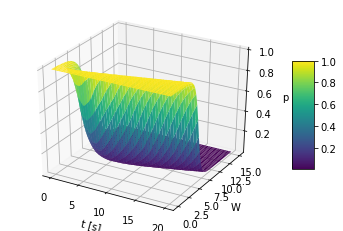

In [14]:
N = 1000
Wmax = 15

batch_size = 1
ts = np.linspace(0, T, N)
Ws = np.linspace(0, Wmax, N)
ts, Ws = np.meshgrid(ts, Ws)
with torch.no_grad():
  Zs = np.array([[p(tensor(Ws[i][j], dtype=torch.float, device=cuda0).view(1, 1), tensor(ts[i][j], dtype=torch.float, device=cuda0)).item() for j in range(N)] for i in range(N)])

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(ts, Ws, Zs, cmap='viridis', edgecolor='none')
ax.set_xlabel('t [s]')
ax.set_ylabel('W')
ax.set_zlabel('p')
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [15]:
!mkdir "drive/MyDrive/MA_Implementation/models"

In [18]:
torch.save(NN.state_dict(), "drive/MyDrive/MA_Implementation/models/large_model.pt")
with open("drive/MyDrive/MA_Implementation/models/large_model_results.json", "w+") as f:
  json.dump({"x": ts.tolist(), "y": Ws.tolist(), "z": Zs.tolist()}, f)

The constant strategy $p = 0$ gives
\begin{align*}
    dW_t = (\pi + r W_t) dt
\end{align*}

With the solution
\begin{align*}
    W_t = \left(W_0 + \frac{\pi}{r} \right) e^{r t} - \frac{\pi}{r}.
\end{align*}
Therefore
\begin{align*}
    W_{20} = \left(1 + \frac{0.1}{0.03} \right) e^{0.03 \cdot 20} - \frac{0.1}{0.03} \approx 4.56
\end{align*}